# GraphSAGE
## Cora 
### TPU

In [10]:
# Add this in a Google Colab cell to install the correct version of Pytorch Geometric.
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric 


# We assume that PyTorch is already installed
import torch
torchversion = torch.__version__

# Install PyTorch Scatter, PyTorch Sparse, and PyTorch Geometric
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{torchversion}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-{torchversion}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Visualization
import networkx as nx
import matplotlib.pyplot as plt

Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html


# Dataset

In [11]:
import torch
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='.', name="Cora")
data = dataset[0]

# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Training nodes: {sum(data.train_mask).item()}')
print(f'Evaluation nodes: {sum(data.val_mask).item()}')
print(f'Test nodes: {sum(data.test_mask).item()}')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Processing...
Done!


Dataset: Cora()
-------------------
Number of graphs: 1
Number of nodes: 2708
Number of features: 1433
Number of classes: 7

Graph:
------
Training nodes: 140
Evaluation nodes: 500
Test nodes: 1000
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


# Mini-batching

Subgraph 0: Data(x=[196, 1433], edge_index=[2, 299], y=[196], train_mask=[196], val_mask=[196], test_mask=[196], batch_size=16)
Subgraph 1: Data(x=[210, 1433], edge_index=[2, 313], y=[210], train_mask=[210], val_mask=[210], test_mask=[210], batch_size=16)
Subgraph 2: Data(x=[235, 1433], edge_index=[2, 330], y=[235], train_mask=[235], val_mask=[235], test_mask=[235], batch_size=16)
Subgraph 3: Data(x=[220, 1433], edge_index=[2, 303], y=[220], train_mask=[220], val_mask=[220], test_mask=[220], batch_size=16)
Subgraph 4: Data(x=[216, 1433], edge_index=[2, 316], y=[216], train_mask=[216], val_mask=[216], test_mask=[216], batch_size=16)
Subgraph 5: Data(x=[246, 1433], edge_index=[2, 362], y=[246], train_mask=[246], val_mask=[246], test_mask=[246], batch_size=16)
Subgraph 6: Data(x=[220, 1433], edge_index=[2, 337], y=[220], train_mask=[220], val_mask=[220], test_mask=[220], batch_size=16)
Subgraph 7: Data(x=[195, 1433], edge_index=[2, 318], y=[195], train_mask=[195], val_mask=[195], test_mas

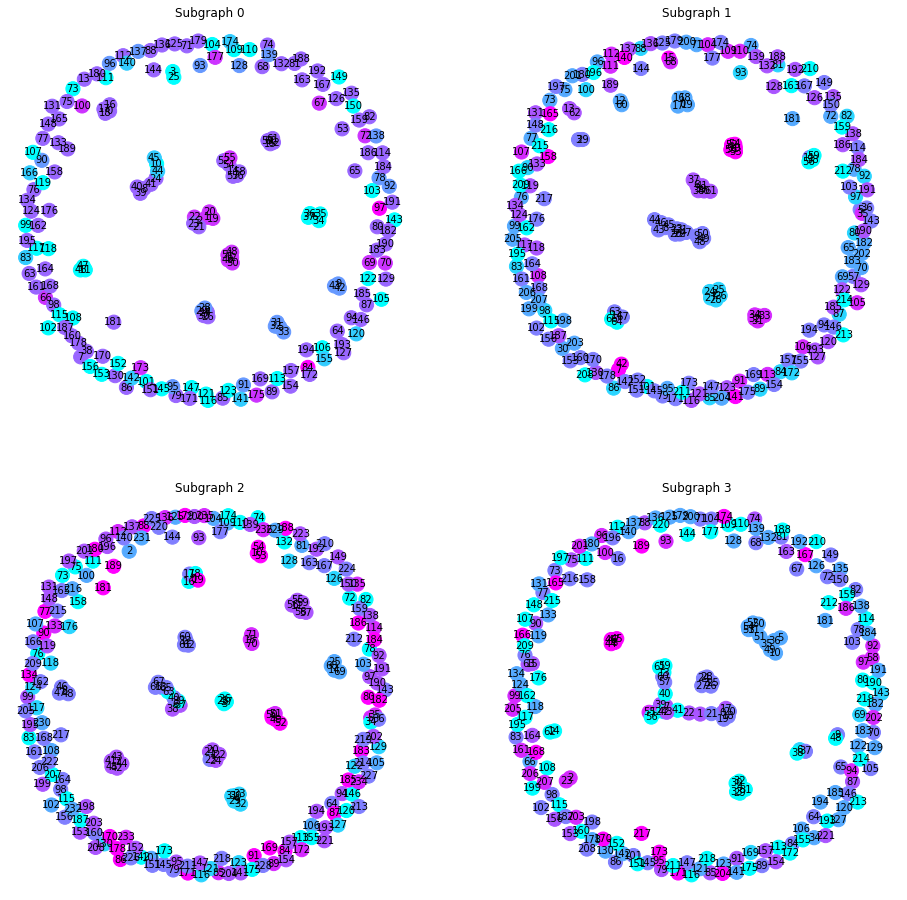

In [12]:
from torch_geometric.loader import NeighborLoader
from torch_geometric.utils import to_networkx

# Create batches with neighbor sampling
train_loader = NeighborLoader(
    data,
    num_neighbors=[5, 10],
    batch_size=16,
    input_nodes=data.train_mask,
)

# Print each subgraph
for i, subgraph in enumerate(train_loader):
    print(f'Subgraph {i}: {subgraph}')

# Plot each subgraph
fig = plt.figure(figsize=(16,16))
for idx, (subdata, pos) in enumerate(zip(train_loader, ['221', '222', '223', '224'])):
    G = to_networkx(subdata, to_undirected=True)
    ax = fig.add_subplot(pos)
    ax.set_title(f'Subgraph {idx}')
    plt.axis('off')
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=True,
                    node_size=200,
                    node_color=subdata.y,
                    cmap="cool",
                    font_size=10
                    )
plt.show()

# Plot node degrees

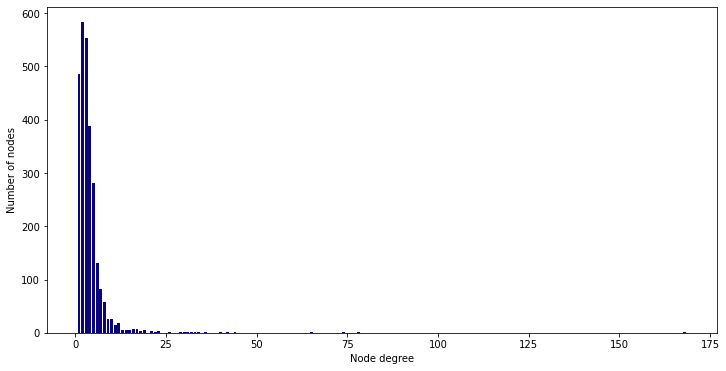

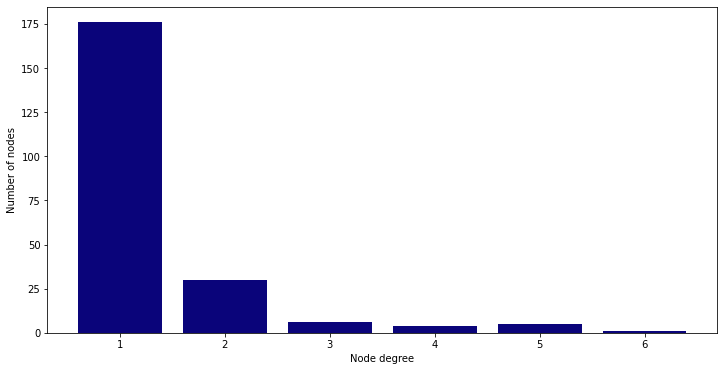

In [13]:
from torch_geometric.utils import degree
from collections import Counter

def plot_degree(data):
  # Get list of degrees for each node
  degrees = degree(data.edge_index[0]).numpy()

  # Count the number of nodes for each degree
  numbers = Counter(degrees)

  # Bar plot
  fig, ax = plt.subplots(figsize=(12, 6))
  ax.set_xlabel('Node degree')
  ax.set_ylabel('Number of nodes')
  plt.bar(numbers.keys(),
          numbers.values(),
          color='#0A047A')

# Plot node degrees from the original graph
plot_degree(data)

# Plot node degrees from the last subgraph
plot_degree(subdata)

# Implement GraphSage vs. GAT vs. GCN

In [14]:
import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch_geometric.nn import SAGEConv, GATv2Conv, GCNConv


class GraphSAGE(torch.nn.Module):
  """GraphSAGE"""
  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.sage1 = SAGEConv(dim_in, dim_h)
    self.sage2 = SAGEConv(dim_h, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = self.sage1(x, edge_index)
    h = torch.relu(h)
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.sage2(h, edge_index)
    return h, F.log_softmax(h, dim=1)

  def fit(self, data, epochs):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = self.optimizer

    self.train()
    for epoch in range(epochs+1):
      total_loss = 0
      acc = 0
      val_loss = 0
      val_acc = 0

      # Train on batches
      for batch in train_loader:
        optimizer.zero_grad()
        _, out = self(batch.x, batch.edge_index)
        loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])
        total_loss += loss
        acc += accuracy(out[batch.train_mask].argmax(dim=1), 
                        batch.y[batch.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss += criterion(out[batch.val_mask], batch.y[batch.val_mask])
        val_acc += accuracy(out[batch.val_mask].argmax(dim=1), 
                            batch.y[batch.val_mask])

      # Print metrics every 10 epochs
      if(epoch % 10 == 0):
          print(f'Epoch {epoch:>3} | Train Loss: {loss/len(train_loader):.3f} '
                f'| Train Acc: {acc/len(train_loader)*100:>6.2f}% | Val Loss: '
                f'{val_loss/len(train_loader):.2f} | Val Acc: '
                f'{val_acc/len(train_loader)*100:.2f}%')

class GAT(torch.nn.Module):
  """Graph Attention Network"""
  def __init__(self, dim_in, dim_h, dim_out, heads=8):
    super().__init__()
    self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
    self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=heads)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.005,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.6, training=self.training)
    h = self.gat1(x, edge_index)
    h = F.elu(h)
    h = F.dropout(h, p=0.6, training=self.training)
    h = self.gat2(h, edge_index)
    return h, F.log_softmax(h, dim=1)

  def fit(self, data, epochs):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = self.optimizer

    self.train()
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()
        _, out = self(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1),
                       data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                           data.y[data.val_mask])

        # Print metrics every 10 epochs
        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                  f' {acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')

class GCN(torch.nn.Module):
  """Graph Convolutional Network"""
  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.gcn1 = GCNConv(dim_in, dim_h)
    self.gcn2 = GCNConv(dim_h, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.5, training=self.training)
    h = self.gcn1(h, edge_index)
    h = torch.relu(h)
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.gcn2(h, edge_index)
    return h, F.log_softmax(h, dim=1)

  def fit(self, data, epochs):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = self.optimizer

    self.train()
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()
        _, out = self(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1),
                       data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                           data.y[data.val_mask])

        # Print metrics every 10 epochs
        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                  f' {acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')
            
def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

def test(model, data):
    """Evaluate the model on test set and print the accuracy score."""
    model.eval()
    _, out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

# Train GraphSAGE

In [15]:
%%time
# Create GraphSAGE
graphsage = GraphSAGE(dataset.num_features, 64, dataset.num_classes)
print(graphsage)

# Train
graphsage.fit(data, 200)

# Test
print(f'\nGraphSAGE test accuracy: {test(graphsage, data)*100:.2f}%\n')

GraphSAGE(
  (sage1): SAGEConv(1433, 64, aggr=mean)
  (sage2): SAGEConv(64, 7, aggr=mean)
)
Epoch   0 | Train Loss: 0.228 | Train Acc:  24.49% | Val Loss: 1.93 | Val Acc: 16.95%
Epoch  10 | Train Loss: 0.002 | Train Acc: 100.00% | Val Loss: 1.15 | Val Acc: 59.36%
Epoch  20 | Train Loss: 0.001 | Train Acc: 100.00% | Val Loss: 1.30 | Val Acc: 55.21%
Epoch  30 | Train Loss: 0.001 | Train Acc: 100.00% | Val Loss: 1.20 | Val Acc: 62.66%
Epoch  40 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 1.31 | Val Acc: 61.61%
Epoch  50 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 1.39 | Val Acc: 57.05%
Epoch  60 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 1.43 | Val Acc: 57.34%
Epoch  70 | Train Loss: 0.001 | Train Acc: 100.00% | Val Loss: 1.39 | Val Acc: 60.37%
Epoch  80 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 1.52 | Val Acc: 58.77%
Epoch  90 | Train Loss: 0.001 | Train Acc: 100.00% | Val Loss: 1.40 | Val Acc: 59.80%
Epoch 100 | Train Loss: 0.012 | Train Acc:  99.4

# Train GCN

In [16]:
%%time

# Create GCN
gcn = GCN(dataset.num_features, 64, dataset.num_classes)
print(gcn)

# Train
gcn.fit(data, 200)

# Test
print(f'\nGCN test accuracy: {test(gcn, data)*100:.2f}%\n')

GCN(
  (gcn1): GCNConv(1433, 64)
  (gcn2): GCNConv(64, 7)
)
Epoch   0 | Train Loss: 1.954 | Train Acc:  12.14% | Val Loss: 1.96 | Val Acc: 8.60%
Epoch  10 | Train Loss: 0.216 | Train Acc:  98.57% | Val Loss: 0.84 | Val Acc: 76.40%
Epoch  20 | Train Loss: 0.046 | Train Acc:  99.29% | Val Loss: 0.95 | Val Acc: 73.40%
Epoch  30 | Train Loss: 0.014 | Train Acc: 100.00% | Val Loss: 1.06 | Val Acc: 73.80%
Epoch  40 | Train Loss: 0.018 | Train Acc: 100.00% | Val Loss: 1.05 | Val Acc: 72.80%
Epoch  50 | Train Loss: 0.009 | Train Acc: 100.00% | Val Loss: 1.13 | Val Acc: 73.60%
Epoch  60 | Train Loss: 0.026 | Train Acc: 100.00% | Val Loss: 1.04 | Val Acc: 70.40%
Epoch  70 | Train Loss: 0.022 | Train Acc: 100.00% | Val Loss: 0.97 | Val Acc: 75.00%
Epoch  80 | Train Loss: 0.019 | Train Acc: 100.00% | Val Loss: 0.93 | Val Acc: 73.40%
Epoch  90 | Train Loss: 0.023 | Train Acc: 100.00% | Val Loss: 0.89 | Val Acc: 72.40%
Epoch 100 | Train Loss: 0.019 | Train Acc: 100.00% | Val Loss: 0.89 | Val Acc: 72

# Train GAT

In [17]:
%%time
# Create GAT
gat = GAT(dataset.num_features, 64, dataset.num_classes)
print(gat)

# Train
gat.fit(data, 200)

# Test
print(f'\nGAT test accuracy: {test(gat, data)*100:.2f}%\n')

GAT(
  (gat1): GATv2Conv(1433, 64, heads=8)
  (gat2): GATv2Conv(512, 7, heads=8)
)
Epoch   0 | Train Loss: 4.032 | Train Acc:   2.14% | Val Loss: 4.03 | Val Acc: 2.00%
Epoch  10 | Train Loss: 0.061 | Train Acc:  99.29% | Val Loss: 0.86 | Val Acc: 74.20%
Epoch  20 | Train Loss: 0.003 | Train Acc: 100.00% | Val Loss: 1.14 | Val Acc: 72.40%
Epoch  30 | Train Loss: 0.001 | Train Acc: 100.00% | Val Loss: 1.11 | Val Acc: 72.20%
Epoch  40 | Train Loss: 0.003 | Train Acc: 100.00% | Val Loss: 1.05 | Val Acc: 71.60%
Epoch  50 | Train Loss: 0.007 | Train Acc: 100.00% | Val Loss: 0.95 | Val Acc: 73.40%
Epoch  60 | Train Loss: 0.009 | Train Acc: 100.00% | Val Loss: 0.93 | Val Acc: 74.20%
Epoch  70 | Train Loss: 0.008 | Train Acc: 100.00% | Val Loss: 0.85 | Val Acc: 74.20%
Epoch  80 | Train Loss: 0.007 | Train Acc: 100.00% | Val Loss: 0.88 | Val Acc: 74.00%
Epoch  90 | Train Loss: 0.007 | Train Acc: 100.00% | Val Loss: 0.92 | Val Acc: 74.80%
Epoch 100 | Train Loss: 0.007 | Train Acc: 100.00% | Val L